In [1]:
import cv2 
import numpy as np 
import math 
import sys 
import os
import matplotlib.pyplot as plt

In [2]:
# Interpolation kernel 
def u(s, a): 
    if (abs(s) >= 0) & (abs(s) <= 1): 
        return (a+2)*(abs(s)**3)-(a+3)*(abs(s)**2)+1
    elif (abs(s) > 1) & (abs(s) <= 2): 
        return a*(abs(s)**3)-(5*a)*(abs(s)**2)+(8*a)*abs(s)-4*a 
    return 0

In [3]:
# Padding 
def pad_image(img, H, W, C): 
    zimg = np.zeros((H+4, W+4, C)) 
    zimg[2:H+2, 2:W+2, :C] = img 
      
    # Pad the first/last two col and row 
    zimg[2:H+2, 0:2, :C] = img[:, 0:1, :C] 
    zimg[H+2:H+4, 2:W+2, :] = img[H-1:H, :, :] 
    zimg[2:H+2, W+2:W+4, :] = img[:, W-1:W, :] 
    zimg[0:2, 2:W+2, :C] = img[0:1, :, :C] 
      
    # Pad the missing eight points 
    zimg[0:2, 0:2, :C] = img[0, 0, :C] 
    zimg[H+2:H+4, 0:2, :C] = img[H-1, 0, :C] 
    zimg[H+2:H+4, W+2:W+4, :C] = img[H-1, W-1, :C] 
    zimg[0:2, W+2:W+4, :C] = img[0, W-1, :C] 
    return zimg 

In [4]:
def bicubic_interpolation(image, ratio, a):
    # Get image size
    height, width, channels = image.shape
    
    # Padding image
    padded_image = pad_image(image, height, width, channels)
    
    # Create new image dimensions
    new_height = math.floor(height * ratio)
    new_width = math.floor(width * ratio)
    
    # Initialize new image
    interpolated_image = np.zeros((new_height, new_width, channels))
    
    step_size = 1 / ratio
    
    for channel in range(channels):
        for y in range(new_height):
            for x in range(new_width):
                # Compute coordinates in original image
                original_x, original_y = x * step_size + 2, y * step_size + 2
                
                # Compute interpolation coefficients
                x1 = 1 + original_x - math.floor(original_x)
                x2 = original_x - math.floor(original_x)
                x3 = math.floor(original_x) + 1 - original_x
                x4 = math.floor(original_x) + 2 - original_x
                
                y1 = 1 + original_y - math.floor(original_y)
                y2 = original_y - math.floor(original_y)
                y3 = math.floor(original_y) + 1 - original_y
                y4 = math.floor(original_y) + 2 - original_y
                
                # Calculate interpolated pixel value
                left_matrix = np.matrix([[u(x1, a), u(x2, a), u(x3, a), u(x4, a)]])
                middle_matrix = np.matrix([[padded_image[int(original_y - y1), int(original_x - x1), channel], 
                                             padded_image[int(original_y - y2), int(original_x - x1), channel], 
                                             padded_image[int(original_y + y3), int(original_x - x1), channel], 
                                             padded_image[int(original_y + y4), int(original_x - x1), channel]], 
                                            [padded_image[int(original_y - y1), int(original_x - x2), channel], 
                                             padded_image[int(original_y - y2), int(original_x - x2), channel], 
                                             padded_image[int(original_y + y3), int(original_x - x2), channel], 
                                             padded_image[int(original_y + y4), int(original_x - x2), channel]], 
                                            [padded_image[int(original_y - y1), int(original_x + x3), channel], 
                                             padded_image[int(original_y - y2), int(original_x + x3), channel], 
                                             padded_image[int(original_y + y3), int(original_x + x3), channel], 
                                             padded_image[int(original_y + y4), int(original_x + x3), channel]], 
                                            [padded_image[int(original_y - y1), int(original_x + x4), channel], 
                                             padded_image[int(original_y - y2), int(original_x + x4), channel], 
                                             padded_image[int(original_y + y3), int(original_x + x4), channel], 
                                             padded_image[int(original_y + y4), int(original_x + x4), channel]]])
                right_matrix = np.matrix([[u(y1, a)], [u(y2, a)], [u(y3, a)], [u(y4, a)]])
                
                interpolated_image[y, x, channel] = np.dot(np.dot(left_matrix, middle_matrix), right_matrix)
    
    return interpolated_image

In [5]:
img = cv2.imread('Sample Images/low_res/0.png') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (128, 128))
img = img/255

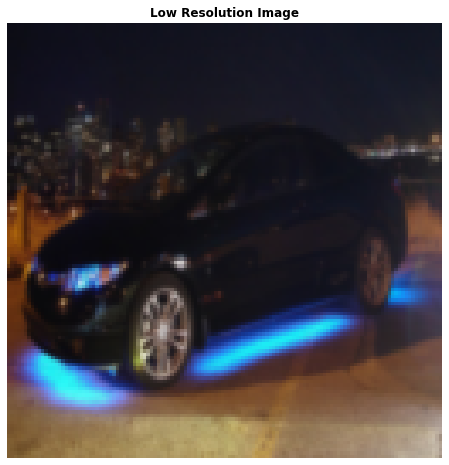

In [6]:
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.title('Low Resolution Image', weight='bold')
plt.show()

In [7]:
# Scale factor 
ratio = 2
# Coefficient 
a = -0.5

# Passing the input image in the bicubic function 
dst = bicubic_interpolation(img, ratio, a) 

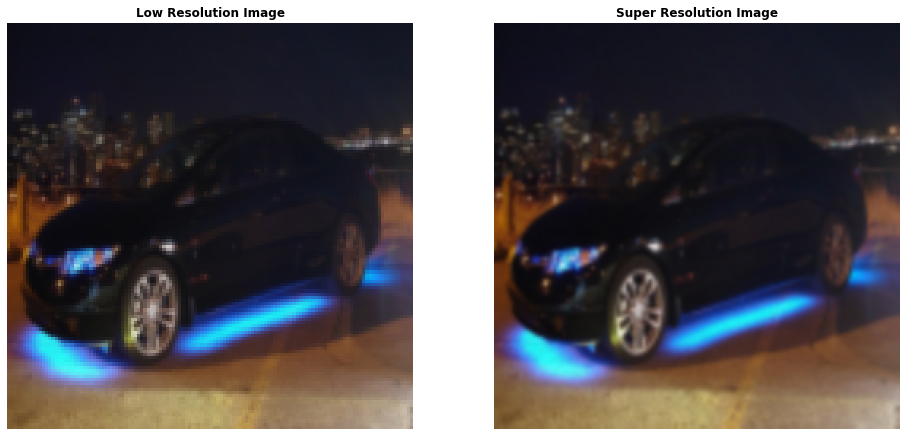

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot the low-resolution image in the first subplot
axs[0].imshow(img)
axs[0].set_title('Low Resolution Image', weight='bold')
axs[0].axis('off')

# Plot the super-resolution image in the second subplot
axs[1].imshow(dst)
axs[1].set_title('Super Resolution Image', weight='bold')
axs[1].axis('off')

# Display the plot
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


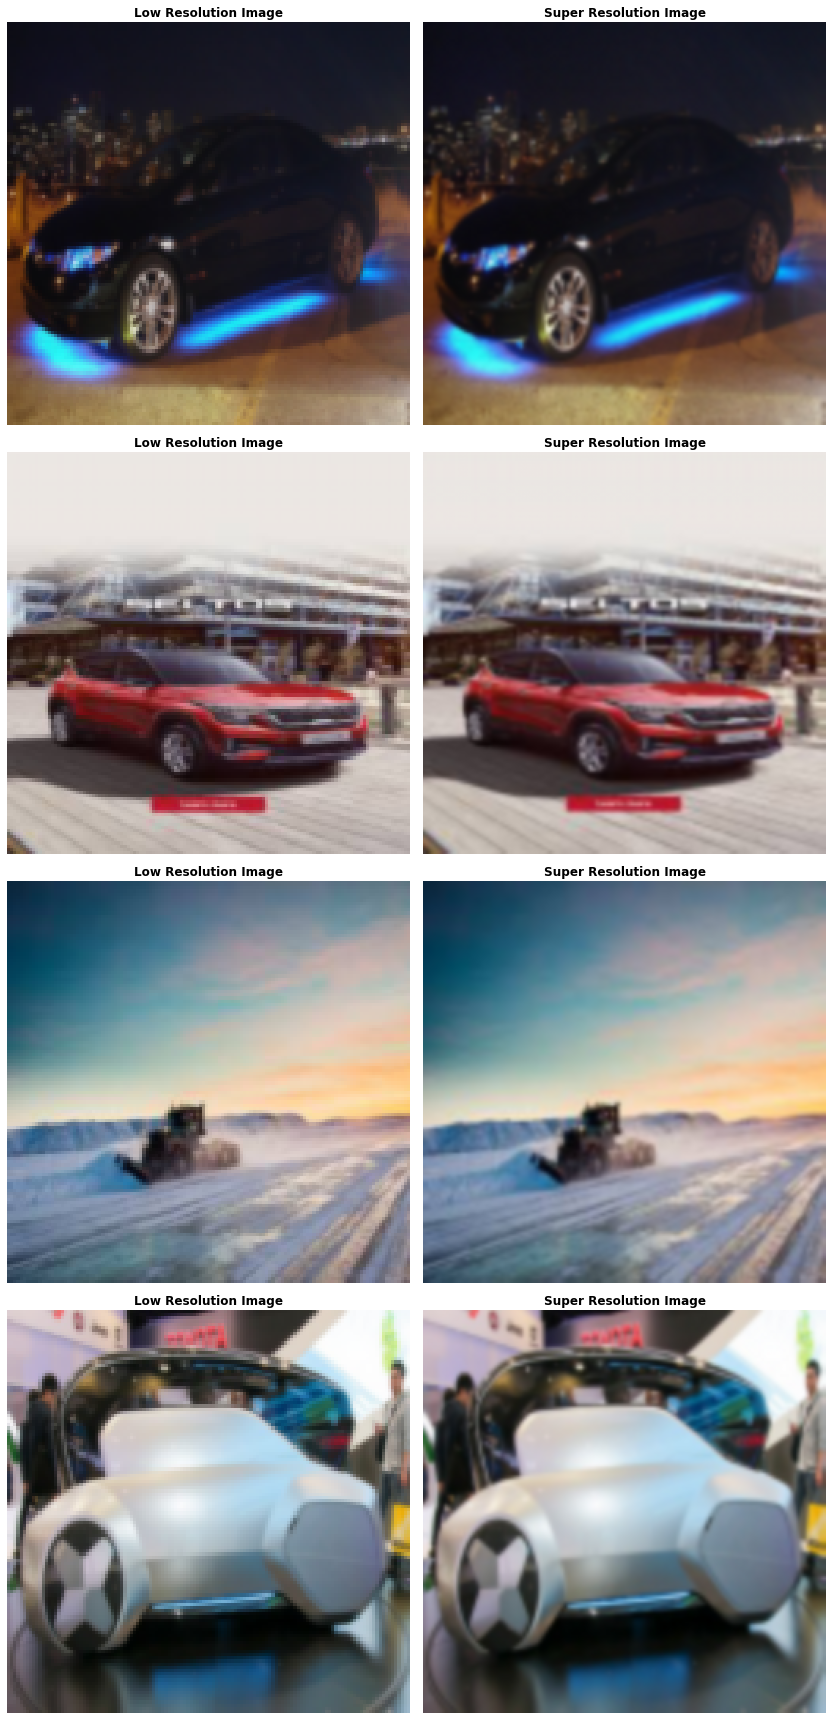

In [9]:
folder_path = 'Sample Images/low_res'

# Get the list of image filenames in the folder
image_files = os.listdir(folder_path)

num_images = len(image_files)
fig, axs = plt.subplots(num_images, 2, figsize=(12, num_images * 6))

for i, filename in enumerate(image_files):
    # Reading the image
    img = cv2.imread(os.path.join(folder_path, filename))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    img = img/255

    # Perform super-resolution
    ratio = 2
    a = -0.5
    dst = bicubic_interpolation(img, ratio, a)

    # Plotting the low-resolution image
    axs[i, 0].imshow(img)
    axs[i, 0].set_title('Low Resolution Image', weight='bold')
    axs[i, 0].axis('off')

    # Plotting the super-resolution image
    axs[i, 1].imshow(dst)
    axs[i, 1].set_title('Super Resolution Image', weight='bold')
    axs[i, 1].axis('off')

# Display the plot
plt.tight_layout()
plt.show()
